# Why Dummy data?

In the real dataset a lot of the reservoirs lack inflow data. Hence, resorting to dummy data

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import random

# Dummy data

In [1]:
from landlab import NetworkModelGrid

In [2]:
y_of_node = (0, 1, 2, 2)
x_of_node = (0, 0, -1, 1)

nodes_at_link=(
    (1, 0),
    (2, 1),
    (3, 1)
)
grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)
grid

<xarray.Dataset>
Dimensions:        (node: 4, link: 3, Two: 2)
Coordinates:
  * node           (node) int64 0 1 2 3
Dimensions without coordinates: link, Two
Data variables:
    mesh           <U1 'a'
    y_of_node      (node) float64 0.0 1.0 2.0 2.0
    x_of_node      (node) float64 0.0 0.0 -1.0 1.0
    nodes_at_link  (link, Two) int64 0 1 2 1 1 3

In [33]:
inflow = grid.add_field(
    'reservoir__unregulated_inflow',
    [3, 2, 1, 1],
    at = 'node',
    units='m3/d',
    clobber=True
)
storage_change = grid.add_field(
    'reservoir__storage_change',
    [0.3, 0.2, -0.1, 0.1],
    at = 'node',
    units='m3/d',
    clobber=True
)
release = grid.add_field(
    'reservoir__release',
    [2.7, 1.8, 1.1, 0.9],
    at = 'node',
    units = 'm3/d',
    clobber=True
)
abstract_elevation = grid.add_field(
    'topographic__elevation',
    [0.0, 1.0, 2.0, 2.0],
    at = 'node',
    units = 'm',
    clobber=True
)
cell_area_at_node = grid.add_field(
    'cell_area_at_node',
    [1, 1, 1, 1],
    at = 'node',
    units = 'm2',
    clobber=True
)


In [34]:
from landlab.components import FlowDirectorSteepest

fdr = FlowDirectorSteepest(grid)
fdr.run_one_step()
fdr

In [23]:
for node in grid.nodes:
    print(grid.adjacent_nodes_at_node[node])

[ 1 -1 -1]
[3 2 0]
[ 1 -1 -1]
[ 1 -1 -1]


In [20]:
grid.links_at_node[0]

array([ 0, -1, -1])

In [105]:
import numpy as np
import numpy.ma as ma

In [116]:
def get_upstream_inflow(grid):
    """Calculates the upstream inflow

    Args:
        grid (_type_): _description_
        node (_type_): _description_

    Returns:
        _type_: _description_
    """
    fdr = FlowDirectorSteepest(grid, abstract_elevation)
    fdr.run_one_step()

    upstream_contributing_links_at_node = np.where(
        fdr.flow_link_incoming_at_node() == 1, grid.links_at_node, -1
    )

    upstream_links = ma.MaskedArray(upstream_contributing_links_at_node, mask=upstream_contributing_links_at_node==-1)
    upstream_nodes = ma.MaskedArray(fdr.upstream_node_at_link()[upstream_links], mask=upstream_links.mask)
    
    regulated_inflow = ma.sum(
        ma.MaskedArray(grid.at_node['reservoir__release'][upstream_nodes], mask=upstream_links.mask), axis=1
    ).filled(0)

    return regulated_inflow

get_upstream_inflow(grid)

array([ 1.8,  2. ,  0. ,  0. ])

# Using StreamflowRegulation component

In [124]:
%load_ext autoreload
%autoreload 2
import numpy as np

from landlab import NetworkModelGrid
y_of_node = (0, 1)#, 2, 2)
x_of_node = (0, 0)#, -1, 1)

nodes_at_link=(
    (1, 0),
    # (2, 1),
    # (3, 1)
)
grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)


grid.add_field(
    "reservoir__total_inflow",
    np.full_like(grid.x_of_node, np.nan),
    at='node',
    units='m3/d' ,
    clobber=True
)
grid.add_field(
    "reservoir__storage_change",
    np.full_like(grid.x_of_node, np.nan),
    at='node',
    units='m3/d' ,
    clobber=True
)
grid.add_field(
    "reservoir__release",
    np.full_like(grid.x_of_node, np.nan),
    at='node',
    units='m3/d' ,
    clobber=True
)
grid.add_field(
    "reservoir__regulated_inflow",
    np.full_like(grid.x_of_node, np.nan),
    at='node',
    units='m3/d' ,
    clobber=True
)
grid.add_field(
    "reservoir__unregulated_inflow",
    np.full_like(grid.x_of_node, np.nan),
    at='node',
    units='m3/d' ,
    clobber=True
)
grid.add_field(
    "reservoir__abstract_elevation",
    (1.0, 0.0),
    at='node',
    units='m' ,
    clobber=True
)
grid.add_field(
    "river__hydraulic_radius",
    (10.0),
    at='link',
    unit='m',
    clobber=True
)
grid.add_field(
    "river__roughness",
    (0.03),
    at='link',
    unit='-',
    clobber=True
)
grid.add_field(
    "river__storage",
    (1000 * 1e6),
    at='link',
    unit='m3',
    clobber=True
)
grid.add_field(
    "river__slope",
    (0.028),  # assuming elevation = 3000, 1600; and distance between reservoirs as 50km
    at='link',
    unit='m/m',
    clobber=True
)
grid.add_field(
    "river__length",
    (1000.0),
    at='link',
    unit='m',
    clobber=True
)


import numpy as np

from landlab.data_record import DataRecord
from reservoirnetwork.reservoir_component import StreamflowRegulation
items = None

time = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

r_A_inflow = np.array([ 120, 130, 90, 60, 30, 20, 30, 20, 15, 15, 10, 9, 9, 9, 8, 9, 90, 150, 120, 100, 80, 70, 50, 40, 30, 23, 16, 10])* 0.1* 1e6
r_A_storage_change = np.array([ 30, 30, 10, 0, 0, -5, 0, -10, -15, -15, -15, -10, -10, -8, -4, -5, 5, 40, 35, 20, 10, 3, -4, -10, -20, -10, -15, -20])* 0.1* 1e6
r_B_inflow = np.array([162, 178, 134, 96, 48, 37, 48, 42, 39, 39, 31, 24.4, 24.4, 22.4, 16.8, 19.4, 139, 200, 157, 140, 118, 109, 84, 74, 68, 46.8, 40.6, 36])* 0.5* 1e6
r_B_storage_change = np.array([ 35, 30, 30, 10, 0, 0, 10, -10, -15, -20, -20, -20, -15, -15, -20, 10, 40, 40, 25, 20, 5, -10, -20, -15, -16, -15, -10, -20])* 0.1* 1e6
last_release = np.array([90, 127]) * 0.1* 1e6

grid.at_node['reservoir__release'] = last_release

# print(StreamflowRegulation.input_var_names)


sr = StreamflowRegulation(grid)


# data_holder = {
#     "reservoir__regulated_inflow": [],
#     "reservoir__unregulated_inflow": [],
#     "river__storage": [],
#     "river__regulated_flow": []
# }
# data = []
node_data = {
    "reservoir__regulated_inflow": np.full((len(time), len(grid.nodes)), np.nan),
    "reservoir__unregulated_inflow": np.full((len(time), len(grid.nodes)), np.nan),
    "reservoir__release": np.full((len(time), len(grid.nodes)), np.nan),
    "reservoir__total_inflow": np.full((len(time), len(grid.nodes)), np.nan)
}
link_data = {
    "river__storage": np.full((len(time), len(grid.active_links)), np.nan),
    "river__regulated_flow": np.full((len(time), len(grid.active_links)), np.nan)
}

for idx, t, inflow, storage_change in zip(
    range(len(time)),
    time, 
    zip(r_A_inflow, r_B_inflow), 
    zip(r_A_storage_change, r_B_storage_change)
):
    # grid.at_node['reservoir__release'] = last_release
    sr.run_one_step(t, inflow, storage_change)
    
    # save node data
    
    # for node_id in enumerate(grid.nodes):
    for key in node_data:
        node_data[key][idx] = grid.at_node[key]
    # for node_id in enumerate(grid.nodes):
    for key in link_data:
        link_data[key][idx] = grid.at_link[key]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import pandas as pd
import xarray as xr

node_ds = []

for var in node_data:
    da = xr.DataArray(
        node_data[var].T, 
        dims = ["node", "time"],
        coords=dict(
            node = grid.nodes,
            time = time
        ),
        name = var
    )
    node_ds.append(da)

node_ds = xr.merge(node_ds)
node_ds


link_ds = []

for var in link_data:
    da = xr.DataArray(
        link_data[var].T, 
        dims = ["link", "time"],
        coords=dict(
            link = grid.active_links,
            time = time
        ),
        name = var
    )
    link_ds.append(da)

link_ds = xr.merge(link_ds)
link_ds

<xarray.Dataset>
Dimensions:                (link: 1, time: 28)
Coordinates:
  * link                   (link) int64 0
  * time                   (time) int64 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28
Data variables:
    river__storage         (link, time) float64 1.051e+09 ... 1.251e+09
    river__regulated_flow  (link, time) float64 2.655e+07 ... 3.254e+07

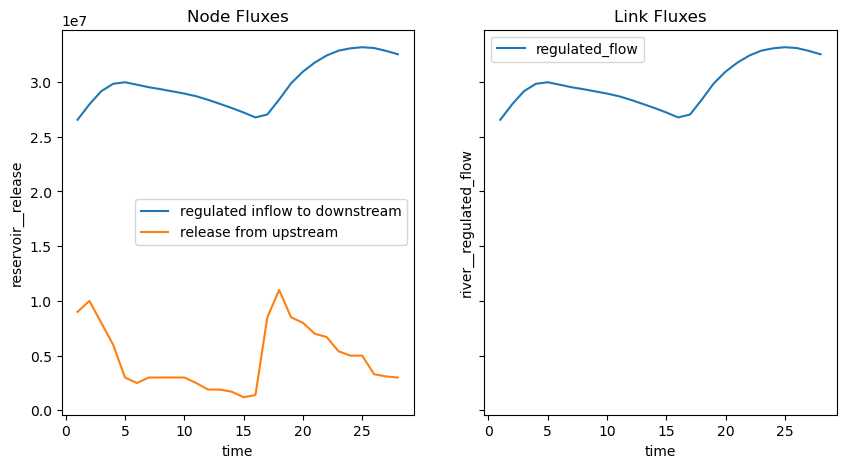

In [133]:
import matplotlib.pyplot as plt

f, (ax, ax1) = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

# node_ds['reservoir__regulated_inflow'].sel(node=1).plot(ax=ax, label='regulated_inflow')
# node_ds['reservoir__unregulated_inflow'].sel(node=1).plot(ax=ax, label='unregulated_inflow')
node_ds['reservoir__regulated_inflow'].sel(node=1).plot(ax=ax, label='regulated inflow to downstream')
node_ds['reservoir__release'].sel(node=0).plot(ax=ax, label='release from upstream')
ax.set_title("Node Fluxes")
ax.legend()

# link_ds['river__release'].sel(node=1).plot(ax=ax, label='regulated_inflow')
# link_ds['river__storage'].sel(link=0).plot(ax=ax1, label='river_storage')
link_ds['river__regulated_flow'].sel(link=0).plot(ax=ax1, label='regulated_flow')
ax1.set_title("Link Fluxes")
ax1.legend()